## data generation

In [1]:
from locally_connected import LocallyConnected
from lbfgsb_scipy import LBFGSBScipy
from trace_expm import trace_expm
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
import numpy as np
import scipy.sparse
import GraphNOTEARS
import notears_torch_version
import lasso
import dynotears
import utils as ut
import matplotlib.pyplot as plt
import networkx as nx
import dgl
import random
import utils as ut
import dgl.function as fn
import torch.nn as nn
import torch.nn.functional as F
from dgl import DGLGraph
import pandas as pd
#device = torch.device("cuda:0")
device = torch.device("cuda")

D:\Anaconda\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
D:\Anaconda\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)

Bad key "text.kerning_factor" on line 4 in
D:\Anaconda\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution
Using backend: pytorch


In [2]:
def data_pre_new(n, d, s0, w_graph_type, p_graph_type, sem_type,ratio):
    #binary W
    w_true = ut.simulate_dag(d, s0, w_graph_type)
    #weighted W
    w_mat = ut.simulate_parameter(w_true)
    w_test_mat=w_mat.copy()
    #A
    adj1 = ut.generate_adj(n) 
    #node to target
    num_target=np.nonzero(w_mat[:,-1])[0]#4,14
    n_suprious=-1.0
    suprious_dict={}
    #if no suprious variable existed
    if len(num_target)==0:
        return w_mat,w_mat, w_mat, w_mat,w_mat,w_mat,n_suprious,w_mat
    else:
        #create the spurious variable
        for i in range(len(num_target)):
            suprious_list=np.nonzero(w_mat[num_target[i],:])[0]#12

            for j in range(len(suprious_list)): 
                suprious=suprious_list[j]
                #count the number of suprious variable
                if suprious not in suprious_dict:
                    suprious_dict[suprious]=1
                    n_suprious+=1
                    #remove other outgoing link
                    w_mat[suprious,:]=0 #12,0
                    w_test_mat[suprious,:]=0
                    #print(suprious)
                    #revert the link in the test
                    if suprious!=d-1:
                        w_test_mat[num_target[i],suprious]=ratio*w_test_mat[num_target[i],suprious]
                
                
    num_step = 5 #cannot work if num_step=1
    #initial X0=X0W+B
    Xbase = []
    Xbase1 = ut.simulate_linear_sem(w_mat, n, sem_type, noise_scale=0.5)
    #X1=X1W+AX0W+B
    for i in range(num_step):
        Xbase1 = ut.simulate_linear_sem_with_P(w_mat, w_mat, adj1@Xbase1, n, sem_type, noise_scale=1)
        Xbase.append(Xbase1)
        
    #test data
    Xbase_test = []
    Xbase1_test = ut.simulate_linear_sem(w_test_mat, n, sem_type, noise_scale=0.5)
    for i in range(num_step):
        Xbase1_test = ut.simulate_linear_sem_with_P(w_test_mat, w_test_mat, adj1@Xbase1_test, n, sem_type, noise_scale=1)
        Xbase_test.append(Xbase1_test)
    
    w_random = ut.simulate_dag(d, s0, w_graph_type)
    return Xbase,Xbase_test, adj1, w_true,w_mat,w_test_mat,n_suprious,w_random

In [4]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)

n = 50 #number of people

d = 10 #number of features

w_graph_type = 'ER'
p_graph_type = 'ER' 
sem_type = 'exp'
s0 =  d
output=pd.DataFrame(columns=["train_acc","valid_acc","test_acc","model","n_suprious"])
ith=0
replicates=100
ratio=-0.3

In [6]:
Xlags,Xlags_test, adj1, w_true,w_mat,w_test_mat,n_suprious,w_random = data_pre_new(n, d, s0, w_graph_type,p_graph_type, sem_type,ratio)

In [ ]:
adj1

In [ ]:
np.shape(torch.Tensor(np.array(Xlags))[:-1])

In [19]:
n_suprious

2.0

In [26]:
np.shape(Xlags)

(5, 50, 5)

In [29]:
adj1

matrix([[0.143, 0.134, 0.   , ..., 0.   , 0.   , 0.   ],
        [0.134, 0.125, 0.204, ..., 0.   , 0.125, 0.   ],
        [0.   , 0.204, 0.333, ..., 0.   , 0.   , 0.   ],
        ...,
        [0.   , 0.   , 0.   , ..., 0.167, 0.   , 0.   ],
        [0.   , 0.125, 0.   , ..., 0.   , 0.125, 0.204],
        [0.   , 0.   , 0.   , ..., 0.   , 0.204, 0.333]])

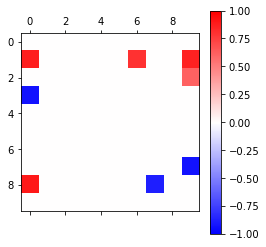

In [26]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.savefig("train_graph.pdf")

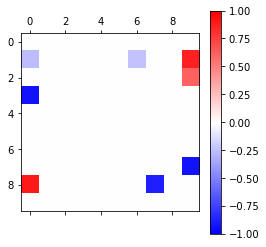

In [27]:
##True W
import matplotlib.pyplot as plt
plt.matshow(w_test_mat,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.savefig("test_graph.pdf")

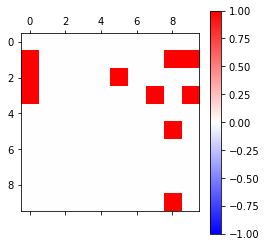

In [9]:
##W_random
import matplotlib.pyplot as plt
plt.matshow(w_random,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.show()

In [18]:
Xlags_torch = torch.Tensor(np.array(Xlags))

adj1_torch = torch.Tensor(adj1)
model_1 = GraphNOTEARS.model_p1_MLP(dims=[d, n, 1], bias=True)
W_est_1, P1_est_1 = GraphNOTEARS.linear_model(model_1, Xlags_torch, adj1_torch,  lambda1 = 0.01, lambda2 = 0.01, lambda3 = 0.01)
print("finish fit graph!")

finish fit graph!


In [22]:
W_est_1[abs(W_est_1)<0.2]=0

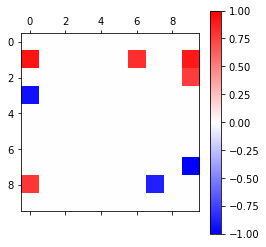

In [25]:
##estimate W
import matplotlib.pyplot as plt
plt.matshow(W_est_1,cmap = 'bwr', vmin = -1, vmax = 1)
plt.colorbar()
plt.savefig("estimated_graph.pdf")

In [99]:
Xlags[-1][:,-1].mean()

0.2204410486384874

In [95]:
Xlags[-1].mean(axis=0)

array([0.202, 0.981, 1.061, 0.768, 0.22 ])

In [91]:
Xlags[-1][:].mean(axis=0)[-1]

0.2204410486384874

In [10]:
def get_node_feature(Xlags,node_num):
#     for num_lags in range(1):
#         if num_lags==0:
#             X_feature=Xlags[num_lags][node_num]
#         else:
#             X_feature=np.append(X_feature,Xlags[num_lags][node_num])##shape num_lags*5 (250)
    X_feature=Xlags[-1][node_num]
    return(X_feature)
def to_binary(x):
    if x>Xlags[-1][:,-1].mean():
        return 1
    else:
        return 0

In [11]:
def create_graph(valid_list,adj1,Xlags,n):
 ##node list for validation
    labels=[]
    G = nx.from_numpy_array(adj1)
    for node_num in range(n):
        G.nodes[node_num]['feature']=get_node_feature(Xlags,node_num)[:-1]

        G.nodes[node_num]['label']=to_binary(get_node_feature(Xlags,node_num)[-1])

        labels.append(G.nodes[node_num]['label'])
        if node_num in valid_list:
            G.nodes[node_num]['train_mask']=False
            G.nodes[node_num]['valid_mask']=True
        else:
            G.nodes[node_num]['train_mask']=True
            G.nodes[node_num]['valid_mask']=False
    g = dgl.from_networkx(G, node_attrs=['feature','label','train_mask','valid_mask'])
    return g

## GAT

In [12]:
class GATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim):
        super(GATLayer, self).__init__()
        self.g = g
        # equation (1)
        self.fc = nn.Linear(in_dim, out_dim, bias=False)
        # equation (2)
        self.attn_fc = nn.Linear(2 * out_dim, 1, bias=False)
    
    def edge_attention(self, edges):
        # edge UDF for equation (2)
        z2 = torch.cat([edges.src['z'], edges.dst['z']], dim=1)
        a = self.attn_fc(z2)
        return {'e' : F.leaky_relu(a)}
    
    def message_func(self, edges):
        # message UDF for equation (3) & (4)
        return {'z' : edges.src['z'], 'e' : edges.data['e']}
    
    def reduce_func(self, nodes):
        # reduce UDF for equation (3) & (4)
        # equation (3)
        alpha = F.softmax(nodes.mailbox['e'], dim=1)
        # equation (4)
        h = torch.sum(alpha * nodes.mailbox['z'], dim=1)
        return {'h' : h}
    
    def forward(self, h):
        # equation (1)
        z = self.fc(h)
        self.g.ndata['z'] = z
        # equation (2)
        self.g.apply_edges(self.edge_attention)
        # equation (3) & (4)
        self.g.update_all(self.message_func, self.reduce_func)
        return self.g.ndata.pop('h')

In [13]:
class MultiHeadGATLayer(nn.Module):
    def __init__(self, g, in_dim, out_dim, num_heads, merge='cat'):
        super(MultiHeadGATLayer, self).__init__()
        self.heads = nn.ModuleList()
        for i in range(num_heads):
            self.heads.append(GATLayer(g, in_dim, out_dim))
        self.merge = merge
    
    def forward(self, h):
        head_outs = [attn_head(h) for attn_head in self.heads]
        if self.merge == 'cat':
            # concat on the output feature dimension (dim=1)
            return torch.cat(head_outs, dim=1)
        else:
            # merge using average
            return torch.mean(torch.stack(head_outs))

In [14]:
class GAT(nn.Module):
    def __init__(self, g, in_dim, hidden_dim, out_dim, num_heads):
        super(GAT, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_dim, hidden_dim, num_heads)
        # Be aware that the input dimension is hidden_dim*num_heads since
        #   multiple head outputs are concatenated together. Also, only
        #   one attention head in the output layer.
        self.layer2 = MultiHeadGATLayer(g, hidden_dim * num_heads, out_dim, 1)
    
    def forward(self, h):
        h = self.layer1(h)
        h = F.elu(h)
        h = self.layer2(h)
        return h

In [15]:
def evaluate(model, g, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [16]:
class atten_Net(nn.Module):
    def __init__(self,g, in_feats, hid_feats, out_feats,n_node,num_heads):
        super(atten_Net, self).__init__()
        self.layer1 = MultiHeadGATLayer(g, in_feats, hid_feats, num_heads)
        self.layer2 = MultiHeadGATLayer(g, hid_feats * num_heads, out_feats, 1)
        self.att_mlp_1 = nn.Linear(n_node, hid_feats)
        self.att_mlp_2 = nn.Linear(hid_feats, 2)
        self.layer3 = MultiHeadGATLayer(g, in_feats*2, hid_feats, num_heads)
        self.layer4 = MultiHeadGATLayer(g, hid_feats * num_heads, out_feats, 1)

    def forward(self, g, features,dag):
        ##use mlp to get attention weights
        node_att = F.relu(self.att_mlp_1(dag))
        node_att = F.softmax(self.att_mlp_2(node_att), dim=-1)
        node_weight_c = node_att[:, 0]
        node_weight_o = node_att[:, 1]
        ##attention on the causal/trival part
        feature_c = node_weight_c.view(1, -1) * features
        feature_o = node_weight_o.view(1, -1) * features
        ## apply the mask on the features
        xc = F.relu(self.layer1(feature_c))
        xc = self.layer2(xc)
        xc=F.log_softmax(xc, dim=-1)
        
        xo = F.relu(self.layer1(feature_o))
        xo = self.layer2(xo)
        xo=F.log_softmax(xo, dim=-1)
        ##xco        
        num = xc.shape[0]
        l = [i for i in range(num)]
        random.shuffle(l)
        random_idx = torch.tensor(l)
        xco = torch.cat((feature_c[random_idx], feature_o), dim=1)
        xco = F.relu(self.layer3(xco))
        xco = self.layer4(xco)
        xco=F.log_softmax(xco, dim=-1)
        
        return xc,xo,xco

In [17]:
def evaluate_new(model, g, features, labels, mask,dag):
    model.eval()
    with torch.no_grad():
        logits_c,logits_o,logits_co = model(g, features,dag)
        logits = logits_o[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [14]:
torch.set_default_dtype(torch.double)
np.set_printoptions(precision=3)

torch.manual_seed(12345)
ut.set_random_seed(12345)

n = 50 #number of people

d = 10 #number of features


w_graph_type = 'ER'
p_graph_type = 'ER' 
sem_type = 'exp'
s0 =  d
#params
ratio=-1
lr=0.005
alpha=0.2
beta=1
gamma=0.2
early_stop_thresh=30
n_epoch=300
output=pd.DataFrame(columns=["train_acc","valid_acc","test_acc","model","n_suprious"])
ith=0
replicates=50
while ith<2*replicates:
    print("-------------------the",ith//2,"iteration------------------")
    #create data
    Xlags,Xlags_test, adj1, w_true,w_mat,w_test_mat,n_suprious,w_random = data_pre_new(n, d, s0, w_graph_type,p_graph_type, sem_type,ratio)
    if n_suprious<=0:
        continue
    Xlags_torch = torch.Tensor(np.array(Xlags))
    print("finish data!")
    #fit the causal graph
#     adj1_torch = torch.Tensor(adj1)
#     model_1 = GraphNOTEARS.model_p1_MLP(dims=[d, n, 1], bias=True)
#     W_est_1, P1_est_1 = GraphNOTEARS.linear_model(model_1, Xlags_torch, adj1_torch,  lambda1 = 0.01, lambda2 = 0.01, lambda3 = 0.01)
#     print("finish fit graph!")
    #g,g_test
    valid_list=random.sample(range(n), int(n*0.4))
    g = create_graph(valid_list,adj1,Xlags,n)
    g_test=create_graph(valid_list,adj1,Xlags_test,n)
#     #GAT
#     net = GAT(g, 
#           in_dim=d-1, 
#           hidden_dim=4, 
#           out_dim=2, 
#           num_heads=2)

    features = g.ndata['feature']
    labels = g.ndata['label']
    train_mask = g.ndata['train_mask']
    valid_mask = g.ndata['valid_mask']
#     ###test
    features_test = g_test.ndata['feature']
    labels_test = g_test.ndata['label']
#     #parameters
#     optimizer = torch.optim.Adam(net.parameters(), lr=lr)

#     best_loss = 99998
#     best_epoch = -1
#     for epoch in range(n_epoch):
#         net.train()
#         logits = net(features)
        
#         logp = F.log_softmax(logits, dim=-1)
#         loss = F.nll_loss(logp[train_mask], labels[train_mask])

#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
#         ##evaluate
#         net.eval()
#         train_acc = evaluate(net, g, features, labels, train_mask)
#         valid_acc = evaluate(net, g, features, labels, valid_mask)
#         test_acc = evaluate(net, g_test, features_test, labels_test, valid_mask)
#         valid_loss = F.nll_loss(logp[valid_mask], labels[valid_mask])
#         #early stop
#         if valid_loss < best_loss:
#             best_loss = valid_loss
#             best_epoch = epoch
#             #torch.save(net.state_dict(), "GCN_demo_large.pth")
#         elif epoch - best_epoch > early_stop_thresh:
#             print("Early stopped training at epoch %d" % epoch)
#             break  # terminate the training loop
#     print("GCN:train",train_acc,"valid",valid_acc,"test",test_acc)
#     output.loc[ith]=[train_acc,valid_acc,test_acc,"GCN",n_suprious]
    ith+=1
    ##proposed
    model = atten_Net(g,num_heads=2,in_feats=d-1, hid_feats=4, out_feats=2,n_node=d)

    #params
    best_loss = 99998
    best_epoch = -1

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    #scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9)
    for epoch in range(n_epoch):
        model.train()
        xc_logits,xo_logits,xco_logits = model(g, features,torch.tensor(w_random[:-1,:]))
        ##trivial part
        uniform_target = torch.ones_like(xc_logits[train_mask], dtype=torch.double)/2
        c_loss = F.kl_div(xc_logits[train_mask], uniform_target, reduction='batchmean')

        o_loss = F.nll_loss(xo_logits[train_mask], labels[train_mask])
        co_loss= F.nll_loss(xco_logits[train_mask], labels[train_mask])
        loss = alpha * c_loss + beta * o_loss +gamma*co_loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #scheduler.step()
        ##evaluate
        model.eval()
        train_acc = evaluate_new(model, g, features, labels, train_mask,torch.tensor(w_random[:-1,:]))
        valid_acc = evaluate_new(model, g, features, labels, valid_mask,torch.tensor(w_random[:-1,:]))
        test_acc = evaluate_new(model, g_test, features_test, labels_test, valid_mask,torch.tensor(w_random[:-1,:]))
        #valid loss
        uniform_target = torch.ones_like(xc_logits[valid_mask], dtype=torch.double)/2
        valid_c_loss = F.kl_div(xc_logits[valid_mask], uniform_target, reduction='batchmean')
        valid_o_loss = F.nll_loss(xo_logits[valid_mask], labels[valid_mask])
        valid_co_loss = F.nll_loss(xco_logits[valid_mask], labels[valid_mask])
        valid_loss = alpha * valid_c_loss+beta *valid_o_loss+gamma*valid_co_loss
        #test loss
        test_xc_logits,test_xo_logits,test_xco_logits = model(g_test, features_test,torch.tensor(w_random[:-1,:]))
        uniform_target = torch.ones_like(test_xo_logits[valid_mask], dtype=torch.double)/2
        test_c_loss = F.kl_div(test_xc_logits[valid_mask], uniform_target, reduction='batchmean')
        test_o_loss = F.nll_loss(test_xo_logits[valid_mask], labels_test[valid_mask])
        test_co_loss = F.nll_loss(test_xco_logits[valid_mask], labels_test[valid_mask])
        test_loss = alpha * test_c_loss + beta * test_o_loss+gamma*test_co_loss
    #early stop     
        if valid_loss < best_loss:
            best_loss = valid_loss
            best_epoch = epoch
            #torch.save(model.state_dict(), "attention_demo_large.pth")
        elif epoch - best_epoch > early_stop_thresh:
            print("Early stopped training at epoch %d" % epoch)
            break  # terminate the training loop
    print("proposed:train",train_acc,"valid",valid_acc,"test",test_acc,"n_suprious",n_suprious)
    output.loc[ith]=[train_acc,valid_acc,test_acc,"proposed",n_suprious]
    ith+=1
    if ith %20==0:
        print(output.groupby("model").mean())

-------------------the 0 iteration------------------
finish data!
Early stopped training at epoch 101
proposed:train 0.8 valid 0.7 test 0.6 n_suprious 2.0
-------------------the 1 iteration------------------
finish data!
Early stopped training at epoch 73
proposed:train 0.8333333333333334 valid 0.55 test 0.3 n_suprious 4.0
-------------------the 2 iteration------------------
finish data!
Early stopped training at epoch 74
proposed:train 0.9333333333333333 valid 0.35 test 0.55 n_suprious 1.0
-------------------the 3 iteration------------------
finish data!
Early stopped training at epoch 120
proposed:train 0.6666666666666666 valid 0.5 test 0.6 n_suprious 3.0
-------------------the 4 iteration------------------
-------------------the 4 iteration------------------
-------------------the 4 iteration------------------
-------------------the 4 iteration------------------
finish data!
Early stopped training at epoch 55
proposed:train 0.7 valid 0.65 test 0.65 n_suprious 2.0
-------------------

Early stopped training at epoch 35
proposed:train 0.6 valid 0.5 test 0.5 n_suprious 2.0
-------------------the 38 iteration------------------
-------------------the 38 iteration------------------
-------------------the 38 iteration------------------
-------------------the 38 iteration------------------
-------------------the 38 iteration------------------
-------------------the 38 iteration------------------
-------------------the 38 iteration------------------
finish data!
Early stopped training at epoch 74
proposed:train 0.8333333333333334 valid 0.65 test 0.45 n_suprious 3.0
-------------------the 39 iteration------------------
finish data!
Early stopped training at epoch 31
proposed:train 0.5666666666666667 valid 0.35 test 0.25 n_suprious 1.0
          train_acc  valid_acc  test_acc  n_suprious
model                                               
proposed     0.7225    0.51375      0.54        2.05
-------------------the 40 iteration------------------
-------------------the 40 itera

In [15]:
output.to_csv("random,gat,d=10,lr=0.005,alpha=0.2,beta=1,gamma=0.2,early_stop_thresh=30,n_epoch=300,ratio=-1.csv")

In [18]:
output.groupby("model").mean()

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
proposed,0.723333,0.516,0.533,1.96


In [19]:
output.groupby("model").std()/np.sqrt(50)

,train_acc,valid_acc,test_acc,n_suprious
model,,,,
proposed,0.016448,0.017228,0.023413,0.13389


In [15]:
diff_list=[]
for i in range(50):
    GCN=output.loc[i*2]["test_acc"]
    proposed=output.loc[i*2+1]["test_acc"]
    diff=proposed-GCN
    diff_list.append(diff)
    

In [17]:
0.112013/np.sqrt(50)

0.01584103037620975